# Readme

### Conda usage
conda activate mpd-ex\
conda deactivate

### File Abreviations
| Kürzel | Name      |
|--------|-----------|
| H      | Home      |
| I      | Ikum      |
| D      | Dammtor   |
| S      | Schwimmen |
| R      | Rudern    |
| O      | Oma       |

Bsp.: H-I = Von Home zum Ikum. Keine Richtung.

# Code

In [23]:
import os
from datetime import timedelta
import datetime as dt

import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd

import matplotlib.pyplot as plt
import seaborn as sns
import keplergl

from pyproj import CRS
from shapely.geometry import Point
import gpxpy

import warnings
warnings.filterwarnings('ignore')

In [2]:
dir = "tracks/"
min_seconds, max_diameter = 5, 10

In [3]:
def load_gpx(dir):
    df = pd.DataFrame()
    geometry = []
    time = []
    points = [[],[]]
    track_name = []


    for file in os.listdir(dir):
        if file.endswith(".gpx"): 
            with open(dir+file, "r") as f:
                gpx = gpxpy.parse(f)
            
                for track in gpx.tracks:
                    for segment in track.segments:
                        for point in segment.points:
                            time.append(point.time)
                            points[0].append(point.longitude)
                            points[1].append(point.latitude)
                            track_name.append(file)

    geometry = [Point(long, lat) for long, lat in zip(points[0],points[1] )]

    df['time'] = time
    df['track_name'] = track_name
    df['geometry'] = geometry

    #Format von df ist richtig! Wird für die TrajectoryCollection in einem DF benötigt und beim Einladen über die id aka. track_name unterschieden.
    #Jeder Eintrag enthält einen Koordinatenpunkt vom Track. Punkte eines gleichen Tracks haben die selbe id.

    return df

In [4]:
df = load_gpx(dir)


gdm = gpd.GeoDataFrame(df, crs = CRS.from_epsg('4326'))
pd.to_datetime(gdm['time']).dt.tz_localize(None)
gdm = gdm.set_index('time')

traj_collection = mpd.TrajectoryCollection(gdm, 'track_name', t='time')

In [29]:
def calc_features(traj_collection):
    data = pd.DataFrame(columns=['id','stoped_time', 'avg_speed','hour'])
    stopPointsArray = []
    
    for traj in traj_collection.trajectories:
        
        detector = mpd.TrajectoryStopDetector(traj)
        stop_points = detector.get_stop_points(min_duration=timedelta(seconds=min_seconds), max_diameter=max_diameter)
        #stop_time = detector.get_stop_time_ranges(min_duration=timedelta(seconds=5), max_diameter=10)
        stop_segments = detector.get_stop_segments(min_duration=timedelta(seconds=min_seconds), max_diameter=max_diameter)

        stopPointsArray.append(stop_points)

        totalStopTime = 0
        totalStopDist = 0

        for seg in stop_segments.trajectories:
            totalStopTime += seg.get_duration().total_seconds()
            totalStopDist += seg.get_length()

        totalMovingTime = traj.get_duration().total_seconds() - totalStopTime
        totalMovingDist = traj.get_length() - totalStopDist

        #final Features
        avgMovingSpeed = (totalMovingDist/totalMovingTime)*3.6      #km/h
        stopTimePerKM = totalStopTime/(traj.get_length()/1000)      #s/km
        start_time = traj.get_start_time().hour
        id = traj.id.split('_')[-1]

        data = data.append({'id' : id, 'stoped_time' : stopTimePerKM, 'avg_speed' : avgMovingSpeed, 'hour': start_time}, ignore_index=True)
    return data, np.asarray(stopPointsArray)


In [ ]:
data, stopPoints = calc_features(traj_collection)

#For the map visualisation
stopPoints = [tracks.reset_index(drop=True).drop(columns=['start_time','end_time']) for tracks in stopPoints]

# Visualisation

In [92]:
data.head()

,id,stoped_time,avg_speed,hour
0,H-I.gpx,6.241869,23.000164,13
1,H-R.gpx,32.415069,20.076509,13
2,H-R.gpx,16.599805,22.560789,16
3,H-I.gpx,6.415803,23.471213,7
4,H-D.gpx,24.031823,17.062661,10


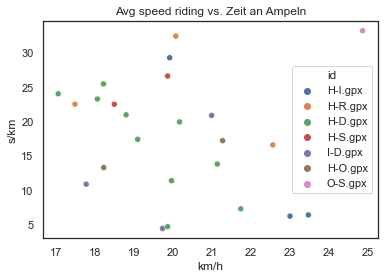

In [87]:
sns.set_style("white")
ax = sns.scatterplot(x="avg_speed", y="stoped_time", hue='id' ,data=data)
ax.set_title("Avg speed riding vs. Zeit an Ampeln")
ax.set_ylabel("s/km")
ax.set_xlabel("km/h")
plt.show()

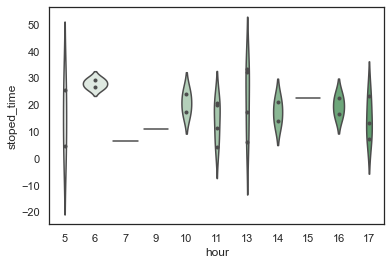

In [89]:
sns.violinplot(x="hour", y="stoped_time", data=data, inner="points", palette="light:g")
plt.show()

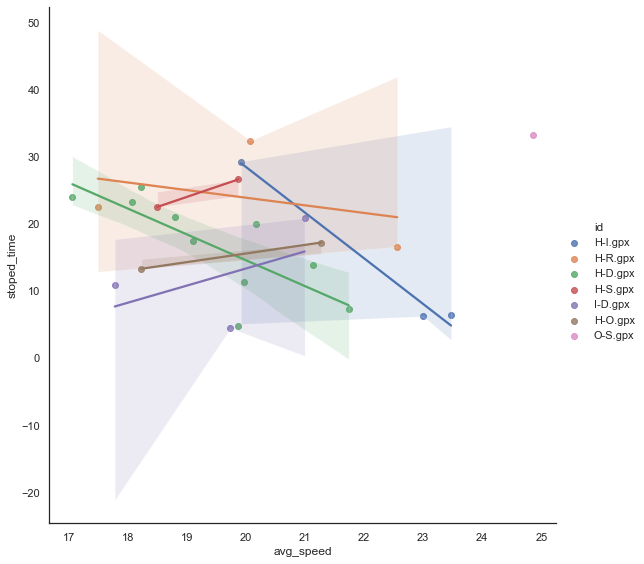

In [84]:
ax = sns.lmplot(x="avg_speed", y="stoped_time", hue='id' ,data=data, height=8)
plt.show()

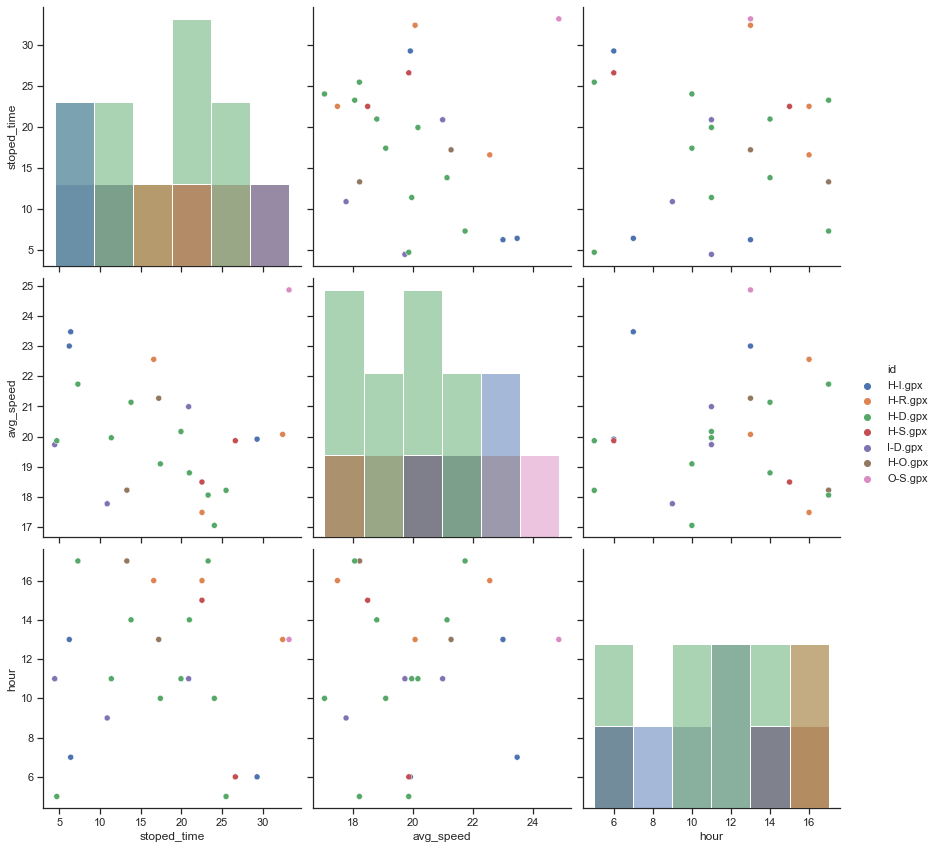

In [91]:
sns.set_theme(style="ticks")
sns.pairplot(data, hue='id',  kind="scatter", diag_kind="hist", height=4)
plt.show()

# Map visualisation

In [8]:
geoDataFrame = gdm.copy()
geoDataFrame = geoDataFrame.reset_index(drop=True)

w1 = keplergl.KeplerGl(height=500)
w1.add_data(geoDataFrame, 'GeoDataFrame')
for i,trips in enumerate(stopPoints):
    w1.add_data(trips.copy(), str(i)+"track")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [9]:
w1.save_to_html(file_name='RideAnalysis.html')
#Open RideAnalysis.html in a browser

Map saved to RideAnalysis.html!
